In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm 
import datetime as dt 

import sys
sys.path.append('/Users/jerald/Documents/Dir/Python/Stocks')
from bin.main import Manager, get_path 

In [2]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
#### Need to be able to do the trend model for both daily and intraday data. 
Connector = Manager(get_path('../../../'))

Options db Connected: 2025-01-19 16:15:23.582014
Prices Connected: 2025-01-19 16:15:23.583123





In [3]:

class price_model: 
    """ 
    Class to find and forecast the trend of a stock. 
    Fits trend finding and forecasting model to returns then reconstructs the predicted price. 
    Models: 
        1. SARIMAX Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors
        2. Exponential Smoothing
        3. ARIMA AutoRegressive Integrated Moving Average
        
    Inputs: 
        df: pandas DataFrame of stock price with datetime index, and columns of 'close'
        forecast_date: datetime or string of the date you want to forecast by. 
        
    Methods:
        1. fit: Fits all models to the data
            1. Fits the SARIMAX model to the data
            2. Fits the Exponential Smoothing model to the data

        2. forecast: Forecasts the price of the stock on the forecast_date
        
        3. plot: Plots the forecasted price of the stock on the forecast_date
    """
    def __init__(self, df, forecast_date):
        self.df = df.rename(columns = {list(df.columns)[-1]:'close'})
        # self.df.index = pd.to_datetime(self.df.index).to_period('B')
        self.forecast_date = forecast_date
        if df.index.to_timestamp()[0].time == dt.time(0, 0):
            self.n_days = pd.bdate_range(self.df.index[-1].to_timestamp(), self.forecast_date).shape[0]
        else: 
            # then the number of days is equal to the periods between the last date and the forecast date
            self.n_days = pd.date_range(self.df.index[-1].to_timestamp(), self.forecast_date, freq = self.df.index.freq).shape[0]
            self.n_days = self.n_days + 10
        
        self.models = {}
        self.returns = self.df['close'].pct_change().dropna()
        self.fit()
        self.predict()
        
    def fit(self):
        ### Seasonal AutoRegressive Integrated Moving average with eXogenous regressors
        self.models['sarimax'] = sm.tsa.statespace.SARIMAX(
                self.returns,
                trend = 'ct', 
                order = (0,0,0),
                time_varying_regression = False,
            ).fit(disp = False, maxiter = 300, method='powell')
    
    def predict(self):
        self.training_forecast = {}; self.forecast = {}
        for model in self.models.keys():
            self.training_forecast[model] = self.models[model].get_prediction(dynamic = self.df.index[-1].to_timestamp())
            self.forecast[model] = self.models[model].get_forecast(steps = self.n_days)
            
    def _reconstruct(self, model, alpha = 0.10):
        """
        Reconstruct the predicted price from the predicted returns
        
            Prices are reconstructed using the last price of the training data, 
            We use the predicted returns to determine 
        
        Args: 
            model: string of the model to reconstruct
            alpha: float of the confidence interval level
        
        Returns:
            train_df: pandas DataFrame of the reconstructed price of the training data
            fdf: pandas DataFrame of the reconstructed price of the forecast data
        
        """
        train_forecast = self.training_forecast[model]
        forecast = self.forecast[model]
        
        # training forecast: Reconstructed price from predicted returns to predicted price
        first_price = self.df['close'].values[0]
        fitted_predictions = train_forecast.predicted_mean
        pred_dy_ci = train_forecast.conf_int(alpha = alpha)
        lowerpred, upperpred = pred_dy_ci.iloc[0,0], pred_dy_ci.iloc[0,1]
        
        # Set first value of array then continue 
        tf = np.array([first_price * (1 + fitted_predictions.iloc[0])])
        upper_tf = np.array([first_price * (1 +  upperpred)])
        lower_tf = np.array([first_price * (1 +  lowerpred)])
        
        # Now fill in the remaining values using the forecasted returns
        for i in range(1, len(fitted_predictions)):
            # tf = np.append(tf, tf[-1] * (1 + fitted_predictions.iloc[i]))
            # upper_tf = np.append(upper_tf, upper_tf[-1] * (1 + pred_dy_ci.iloc[i,1]))
            # lower_tf = np.append(lower_tf, lower_tf[-1] * (1 + pred_dy_ci.iloc[i,0]))
            pred_price = tf[-1] * (1 + fitted_predictions.iloc[i])
            upper_pred = tf[-1] * (1 + pred_dy_ci.iloc[i,1])
            lower_pred = tf[-1] * (1 + pred_dy_ci.iloc[i,0])
            
            tf = np.append(tf, pred_price)
            upper_tf = np.append(upper_tf, upper_pred)
            lower_tf = np.append(lower_tf, lower_pred)
            
            
        train_df = self.df.iloc[1:].copy()
        train_df['prediction'] = tf
        train_df['lower'] = lower_tf
        train_df['upper'] = upper_tf
        
        # forecast: Reconstructed price from predicted returns to predicted price
        last_price = self.df['close'].values[-1]
        forecast_fit = forecast.predicted_mean
        forecast_ci = forecast.conf_int(alpha = alpha)
        new_ind = forecast_fit.index
        
        # Set first value of array then continue
        f = np.array([last_price * (1 + forecast_fit.iloc[0])])
        uf = np.array([last_price * (1 + forecast_ci.iloc[0,1])])
        lf = np.array([last_price * (1 + forecast_ci.iloc[0,0])])
        
        # Now fill in the remaining values using the forecasted returns
        for i in range(1, len(forecast_fit)):
            f = np.append(f, f[-1] * (1 + forecast_fit.iloc[i]))
            uf = np.append(uf, f[-1] * (1 + forecast_ci.iloc[i,1]))
            lf = np.append(lf, f[-1] * (1 + forecast_ci.iloc[i,0]))
        
        fdf = pd.DataFrame(f, index = new_ind, columns = ['prediction'])
        fdf['lower'] = lf
        fdf['upper'] = uf
        fdf = fdf[fdf.index >= self.df.index[-1]]
        
        return train_df, fdf
    
    def plot_model(self, ax, model = 'sarimax', alpha = 0.10):
        d, fdf = self._reconstruct(model, alpha = alpha)
        d.index = d.index.to_timestamp()
        fdf.index = fdf.index.to_timestamp()
        ax.plot(d.index, d['close'], label = 'Close', color = 'blue')
        ax.plot(d.index, d['close'].ewm(alpha = 1/10).mean(), label = 'Close', color = 'gold')
        ax.plot(d.index, d['close'].ewm(alpha = 1/20).mean(), label = 'Close', color = 'teal')
        ax.plot(d.index, d['prediction'], label = 'Prediction', color = 'red')
        ax.plot(fdf.index, fdf['prediction'], label = 'Earnings Prediction', color = 'green', linestyle = '--')
        ax.fill_between(fdf.index, fdf['lower'], fdf['upper'], color = 'green', alpha = 0.2)
        ax.fill_between(d.index, d['lower'], d['upper'], color = 'grey', alpha = 0.2)
        ax.plot()
        

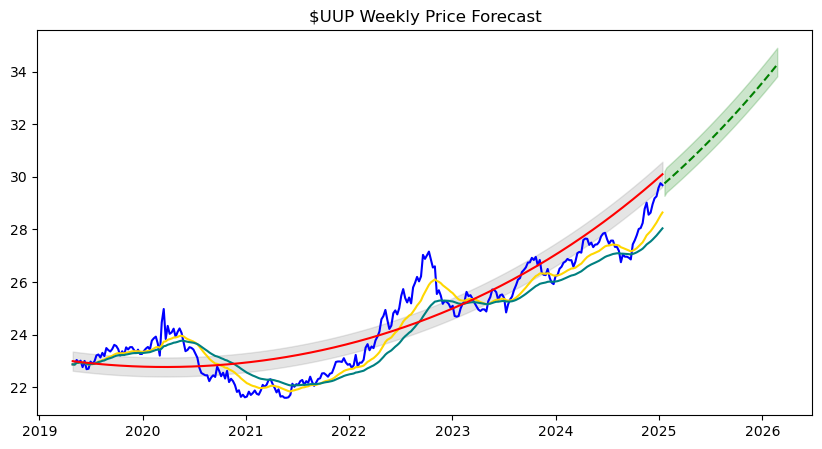

In [27]:
# ['AMZN', 'AAPL', 'DKNG', 'SQ', 'INTC', 'ARDX', 'RKT', 'RBLX', 'COIN', 'SNAP', 'CTRA', 'ROKU', 'X', 'MARA', 'EOG', 'CLX', 'K', 'DASH', 'OPEN']
# df_dict = Connector.Pricedb.intraday_aggregates('spy')
stocks = Connector.Optionsdb.all_stocks
stock = np.random.choice(stocks)
df_dict = Connector.Pricedb.daily_aggregates(stock)
names = list(df_dict.keys())
long_names = dict(zip(names, ['Daily', 'Weekly', 'Monthly']))
date_dict = {names[i]:df_dict[names[i]].index.to_period(names[i]) for i in range(len(names))}
n = 1
df = df_dict[names[n]].copy()
dates = date_dict[names[n]].copy()
vals = df.values
mdf = pd.DataFrame(vals, index = dates, columns = ['close'])
mdf.index.to_timestamp().time[0] == dt.time(0,0)

p = price_model(mdf.tail(300), pd.to_datetime('2025-12-16'))
fig, ax = plt.subplots(1,1, figsize = (10,5))
p.plot_model(ax, model = 'sarimax', alpha = 0.10)
ax.set_title(f'${stock.upper()} {long_names[names[n]]} Price Forecast')
plt.show()

In [15]:
names

['B', 'W', 'M']

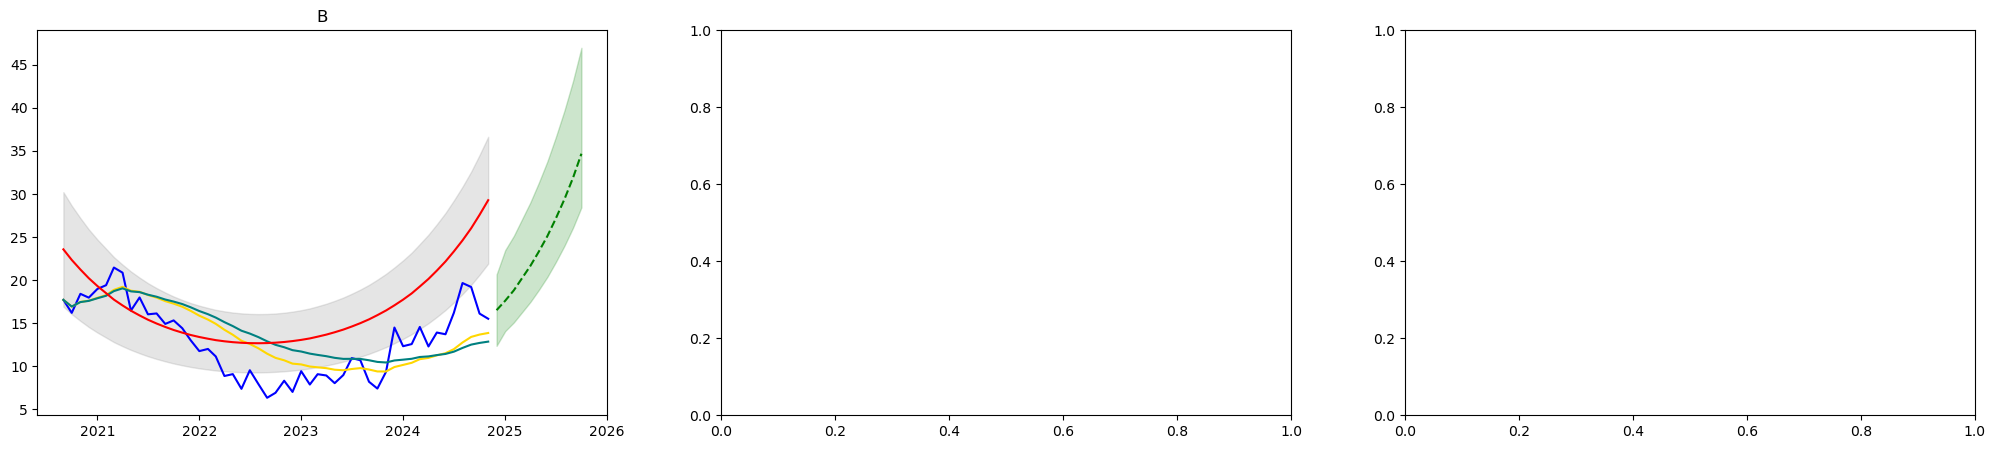

In [6]:
fig, ax = plt.subplots(1,3, figsize = (25,5))
ax = ax.flatten()
for i, n in enumerate(names):
    df = df_dict[n].copy()
    dates = date_dict[n].copy()
    vals = df.values
    mdf = pd.DataFrame(vals, index = dates, columns = ['close'])
    mdf.index.to_timestamp().time[0] == dt.time(0,0)
    p.plot_model(ax[i], model = 'sarimax', alpha = 0.10)
    ax[i].set_title(n)
    plt.show()
    break

In [10]:
names

['B', 'W', 'M']

In [6]:
p._reconstruct('sarimax')[1].head(5)

,prediction,lower,upper
2024-10-25,11.101538,10.687644,11.514473
2024-10-28,11.101038,10.687143,11.513934
2024-10-29,11.100519,10.686623,11.513376
2024-10-30,11.099981,10.686086,11.512798
2024-10-31,11.099423,10.685530,11.512201
